In [2]:
import numpy as np
import tensorflow as tf
import os
import cv2
import pandas as pd
import string
import matplotlib.pyplot as plt


from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.activations import relu, sigmoid, softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

from tensorflow.keras import backend as K #Import the tensorflow.keras backend
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Reshape, Bidirectional, LSTM, Dense, Activation, Lambda, BatchNormalization, Dropout, LayerNormalization

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from tensorflow.keras import layers
import Levenshtein

In [3]:
with open('Dataset/words_new.txt') as f:
    cnts = f.readlines()

lines = [line.strip() for line in cnts][18:]

In [4]:
maxlen = 0

chars = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(chars, len(chars))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(chars.index(chara))

    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [5]:
images = []
labels = []

RECORDS_COUNT = 40000

In [6]:
trn_img = []
trn_lbls = []
trn_inplen = []
trn_lbllen = []
trn_org_text = []

valid_img = []
valid_lbls = []
valid_inplen = []
valid_lbllen = []
valid_org_text = []

inp_len = []
lbl_len = []

In [7]:
def process_image(img):
    
    #Converts image to shape (32, 128, 1) & normalizes it
    
    w, h = img.shape
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape

    img = img.astype('float32')

  
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape

    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape

    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)

    img = cv2.subtract(255, img)

    img = np.expand_dims(img, axis=2)

    # # Normalize
    img = img / 255.0
    return img

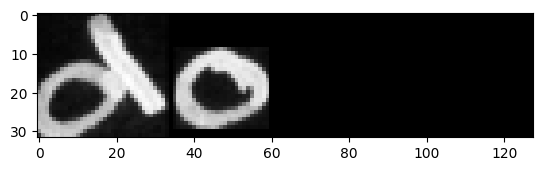

In [8]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]

    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])

        splits_id = word_id.split('-')
        filepath = 'Dataset/iam_words/words/{}/{}-{}/{}.png'.format(splits_id[0], splits_id[0],  splits_id[1], word_id)

        # process image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue

        # process label
        try:
            label = encode_to_labels(word)
        except:
            continue

        if index % 10 == 0:
            valid_img.append(img)
            valid_lbls.append(label)
            valid_inplen.append(31)
            valid_lbllen.append(len(word))
            valid_org_text.append(word)
        else:
            trn_img.append(img)
            trn_lbls.append(label)
            trn_inplen.append(31)
            trn_lbllen.append(len(word))
            trn_org_text.append(word)

        if len(word) > maxlen:
            maxlen = len(word)

    if index >= RECORDS_COUNT:
        break


#display test image in grayscale 

plt.imshow(trn_img[647], cmap='gray') 
plt.show()

In [39]:
train_padded_label = pad_sequences(trn_lbls,
                             maxlen=maxlen,
                             padding='post',
                             value=len(chars))

valid_padded_label = pad_sequences(valid_lbls,
                             maxlen=maxlen,
                             padding='post',
                             value=len(chars))

valid_padded_label[23]

train_padded_label.shape, valid_padded_label.shape

((31136, 19), (3463, 19))

In [40]:
trn_img = np.asarray(trn_img)
trn_inplen = np.asarray(trn_inplen)
trn_lbllen = np.asarray(trn_lbllen)

valid_img = np.asarray(valid_img)
valid_inplen = np.asarray(valid_inplen)
valid_lbllen = np.asarray(valid_lbllen)

trn_img.shape

(31136, 32, 128, 1)

In [41]:
def model_def(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 1))(x)
    x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 1))(x)
    
    x = layers.Reshape((-1, x.shape[-1]))(x)

    x = Bidirectional(LSTM(512, return_sequences=True))(x)
    x = Bidirectional(LSTM(512, return_sequences=True, dropout=0.2))(x)
    x = Bidirectional(LSTM(512, return_sequences=True, dropout=0.3))(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

In [42]:
input_shape = (32, 128, 1)
num_classes = len(chars) + 1  # +1 for CTC blank
model = model_def(input_shape, num_classes)

# CTC loss function
def ctc_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    return keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 128, 128)   │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 32, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 32, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 32, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 32, 1024)    │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 32, 1024)    │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 32, 1024)    │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 32, 1024)    │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 32, 1024)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 64, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64, 1024)       │     6,295,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 64, 1024)       │     6,295,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64, 1024)       │     6,295,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64, 79)         │        80,975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,610,255 (132.03 MB)

 Trainable params: 34,606,159 (132.01 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [43]:
class AccuracyCallback(keras.callbacks.Callback):
    def __init__(self, validation_data, chars, maxlen):
        super(AccuracyCallback, self).__init__()
        self.validation_data = validation_data
        self.chars = chars
        self.maxlen = maxlen

    def calculate_cer(self, ground_truth, predicted):

        #error per character

        edit_distance = Levenshtein.distance(ground_truth, predicted)
        cer = edit_distance / len(ground_truth)
        return cer

    def calculate_wer(self, ground_truth, predicted):

        #error per word

        ground_truth_words = ground_truth.split()
        predicted_words = predicted.split()
        edit_distance = Levenshtein.distance(ground_truth_words, predicted_words)
        wer = edit_distance / len(ground_truth_words)
        return wer

    def decode_predictions(self, predictions):

        #CTC Decoding

        input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
        results = keras.backend.ctc_decode(predictions,
                                           input_length=input_len,
                                           greedy=True)[0][0]
        decoded_texts = []
        for result in results:
            decoded_text = ''.join([self.chars[int(i)] for i in result if int(i) != -1])
            decoded_texts.append(decoded_text)
        return decoded_texts

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        predictions = self.model.predict(x_val)
        decoded_texts = self.decode_predictions(predictions)

        total_cer = 0
        total_wer = 0
        num_samples = len(decoded_texts)

        y_val_texts = []
        for y in y_val:
          text = ''.join([self.chars[int(i)] for i in y if int(i) != len(self.chars)])
          y_val_texts.append(text)


        for i in range(num_samples):
            cer = self.calculate_cer(y_val_texts[i], decoded_texts[i])
            wer = self.calculate_wer(y_val_texts[i], decoded_texts[i])
            total_cer += cer
            total_wer += wer

        avg_cer = total_cer / num_samples
        avg_wer = total_wer / num_samples

        print(f"-Character Acc: {((1-avg_cer)*100):.4f}% -Word Acc: {((1-avg_wer)*100):.4f}%")

In [44]:
accuracy_callback = AccuracyCallback(validation_data=(valid_img, valid_padded_label), chars=chars, maxlen=maxlen)

In [45]:
model.compile(optimizer='adam', loss=ctc_loss)

In [48]:


# uncomment the early stopping part if you want to reduce the chances of overfitting
# i had fluctuation of error rates after 12 epochs
history = model.fit(
    
    x=trn_img,
    y=train_padded_label,
    validation_data=(valid_img, valid_padded_label),
    batch_size=32,
    epochs=25,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            "best_model.keras",
            save_best_only=True,
            monitor="val_loss"
        ),
        #keras.callbacks.EarlyStopping(
        #    patience=3,
        #    monitor="val_loss"
        #),
        accuracy_callback 
    ]
)

Epoch 1/25


KeyboardInterrupt: 

In [9]:

model.save('hwai.keras')

NameError: name 'model' is not defined

In [58]:
loaded_model = keras.models.load_model('best_model.keras', custom_objects={'ctc_loss': ctc_loss})

In [ ]:
image_path=r'drawing.png'
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img = process_image(img)

pic = np.asarray(img)
plt.imshow(pic, cmap=plt.cm.gray)
plt.show()
print(' ')

img = np.expand_dims(img, axis=0)
prediction = loaded_model.predict(img)
input_len = np.ones(prediction.shape[0]) * prediction.shape[1]
results = keras.backend.ctc_decode(prediction,
                                    input_length=input_len,
                                    greedy=True)[0][0]

output_text = []
for result in results:
    result = ''.join([chars[int(i)] for i in result if int(i) != -1])
    output_text.append(result)

predicted_text=output_text[0]
print(f"Predicted text: {predicted_text}")


# you can go onto paint.py and use this model easily insteaed of running all of this too 

NameError: name 'cv2' is not defined